In [1]:
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
from scipy.stats import beta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, cross_val_predict

%matplotlib inline

# Exploration

In [2]:
df = pd.read_csv('../data/digitiser_dataset.csv', index_col=0)
df = df[df['x_questions']==20]
df.head(10)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions
0,-1,Lio,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
1,-1,Sara,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
2,3,Marilou,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
3,-1,Chloé,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
4,-1,Iluna,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
5,3,Mira,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
6,-1,Zoë,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
7,-1,Helena,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
8,-1,June,3,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
9,3,Léa,3,1,True,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20


In [3]:
views = df['name'].value_counts()
views.head()

Anna     3164
Zoé      3071
Lou      2898
Laura    2897
Elize    2894
Name: name, dtype: int64

In [4]:
clicks = df.loc[df['feedback']==3,'name'].value_counts()
clicks.head()

Anna    1224
Lou     1205
Nora    1203
Lili    1159
Ella    1112
Name: name, dtype: int64

In [5]:
clicks_per_view = clicks / views
name_df = pd.DataFrame({'clicks':clicks, 'views':views, 'clicks_per_view':clicks_per_view})
name_df.sort_values('clicks_per_view', ascending=False).head()

,clicks,clicks_per_view,views
Charlie,1.0,1.000000,1
Minne,2.0,0.666667,3
Annabelle,2.0,0.666667,3
Ella,1112.0,0.555445,2002
Nore,501.0,0.524059,956


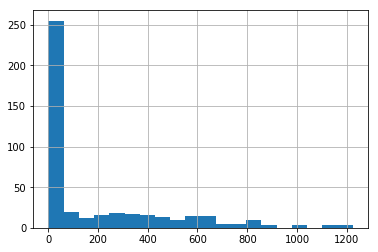

In [6]:
name_df['clicks'].hist(bins=20)

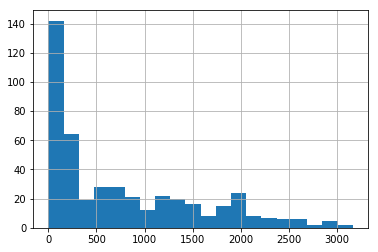

In [7]:
name_df['views'].hist(bins=20)

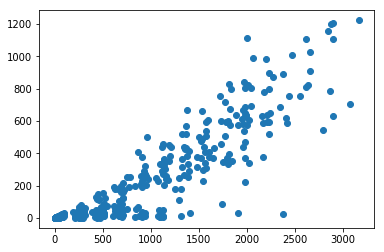

In [8]:
plt.scatter(name_df['views'], name_df['clicks'])

# Bayesian clicks per view

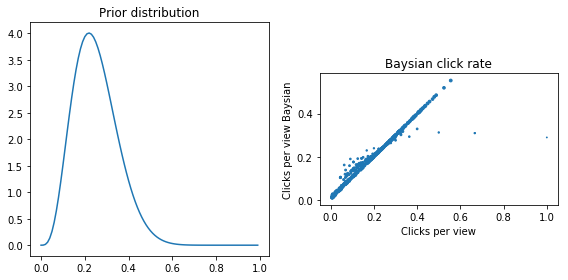

In [9]:
# Get the occurence dataframe
name_df['clicks'] = name_df['clicks'].fillna(0)

# Calcultate parameters of the priors
mu = 0.25
var = 0.06
prior_a = np.power(((1. - mu) / var - 1. / mu) * mu , 2)
prior_b = prior_a * (1. / mu - 1.)

x = np.arange(0, 1, 0.01)
distribution = beta.pdf(x, prior_a, prior_b)

def calculate_baysian_mean(views, clicks):
    non_clicks = views - clicks
    if(views==0): print('no views')
    mean, var, skew, kurt = beta.stats(prior_a + clicks, prior_b + non_clicks, moments='mvsk')
    return mean

# Calculate for each name the baysian clicks per view
name_df['clicks_per_view_baysian'] = name_df.apply(lambda row: calculate_baysian_mean(row['views'], row['clicks']), axis=1)
name_df['clicks_per_view_baysian'] = name_df['clicks_per_view_baysian'].astype(float)

# Some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(x, distribution)
axes[0].set_title('Prior distribution')

axes[1].scatter(name_df['clicks_per_view'], name_df['clicks_per_view_baysian'], s=np.log(name_df['views']+1))
axes[1].set_title('Baysian click rate')
axes[1].set_xlabel('Clicks per view')
axes[1].set_ylabel('Clicks per view Baysian')
axes[1].set_aspect('equal')

fig.tight_layout()



# Baseline


In [10]:
popularity = pd.read_csv('../data/popularity.csv')
popularity.head()

,name,sex,region,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,Aagje,F,Vlaanderen,0.0,10.0,7.0,6.0,5.0,0.0,12.0,...,10.0,11.0,12.0,11.0,8.0,11.0,7.0,0.0,0.0,0.0
1,Aaliyah,F,Vlaanderen,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,8.0,7.0,14.0,9.0,9.0,7.0,10.0,11.0,8.0,13.0
2,Abigail,F,Vlaanderen,0.0,0.0,8.0,0.0,0.0,0.0,5.0,...,0.0,6.0,7.0,8.0,16.0,11.0,10.0,10.0,11.0,12.0
3,Ada,F,Vlaanderen,0.0,0.0,0.0,0.0,5.0,0.0,6.0,...,12.0,19.0,17.0,20.0,24.0,19.0,28.0,32.0,35.0,27.0
4,Adeline,F,Vlaanderen,15.0,10.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,6.0,8.0,0.0,8.0,0.0,12.0


In [11]:
df['question_id'] = df['model_id'] + '_' + df['question'].astype(str)
df['question_id'].head(12)

0     3dxqYZDIqnnbnJRwd9xF_1
1     3dxqYZDIqnnbnJRwd9xF_1
2     3dxqYZDIqnnbnJRwd9xF_1
3     3dxqYZDIqnnbnJRwd9xF_1
4     3dxqYZDIqnnbnJRwd9xF_2
5     3dxqYZDIqnnbnJRwd9xF_2
6     3dxqYZDIqnnbnJRwd9xF_2
7     3dxqYZDIqnnbnJRwd9xF_2
8     3dxqYZDIqnnbnJRwd9xF_3
9     3dxqYZDIqnnbnJRwd9xF_3
10    3dxqYZDIqnnbnJRwd9xF_3
11    3dxqYZDIqnnbnJRwd9xF_3
Name: question_id, dtype: object

In [12]:
most_popular = (
    pd.merge(
        df, 
        popularity, 
        left_on = 'name', 
        right_on = 'name')
     .sort_values('year_2016', ascending=False)
     .groupby('question_id')['name'].first())
clicked = df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

In [13]:
most_popular.head()

question_id
00329XrhSh1vtc7swjcP_1     Lucie
00329XrhSh1vtc7swjcP_11    Emily
00329XrhSh1vtc7swjcP_12     Lore
00329XrhSh1vtc7swjcP_13     Emma
00329XrhSh1vtc7swjcP_14     Ella
Name: name, dtype: object

In [14]:
clicked.head()

question_id
00329XrhSh1vtc7swjcP_1        Mona
00329XrhSh1vtc7swjcP_11    Paulien
00329XrhSh1vtc7swjcP_12       Maya
00329XrhSh1vtc7swjcP_13    Phaedra
00329XrhSh1vtc7swjcP_14        Zoé
Name: name, dtype: object

In [15]:
questions = pd.DataFrame({'most_popular':most_popular, 'clicked':clicked})
questions.head()

,clicked,most_popular
question_id,,
00329XrhSh1vtc7swjcP_1,Mona,Lucie
00329XrhSh1vtc7swjcP_11,Paulien,Emily
00329XrhSh1vtc7swjcP_12,Maya,Lore
00329XrhSh1vtc7swjcP_13,Phaedra,Emma
00329XrhSh1vtc7swjcP_14,Zoé,Ella


In [16]:
(questions['clicked'] == questions['most_popular']).mean()

0.36012228260869567

The popularity based recommender guesses clicks correctly **36%** of the time

# Content-based recommender

## Modeling for a single user

In [17]:
feature_df = pd.read_csv('../data/features.csv', index_col=0)

In [18]:
df['target'] = df['feedback'].map({-1:0, 3:1})

In [19]:
model_id = df['model_id'].sample().iloc[0]
model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name')
model_df.head(12)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions,question_id,target,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,3,Marie-Lou,1,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_1,1,...,8.0,7.0,12.0,27.0,27.0,35.0,38.0,46.0,55.0,56.0
1,-1,Niene,1,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_1,0,...,7.0,10.0,23.0,19.0,20.0,30.0,29.0,35.0,34.0,21.0
2,-1,Jana,1,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_1,0,...,124.0,132.0,189.0,118.0,94.0,111.0,113.0,91.0,69.0,48.0
3,-1,Lara,1,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_1,0,...,145.0,111.0,91.0,110.0,90.0,105.0,86.0,99.0,85.0,88.0
4,-1,Elena,2,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_2,0,...,113.0,120.0,158.0,146.0,185.0,181.0,181.0,220.0,232.0,193.0
5,3,Nell,2,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_2,1,...,25.0,22.0,17.0,27.0,30.0,39.0,43.0,53.0,60.0,47.0
6,-1,Imane,2,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_2,0,...,47.0,41.0,39.0,37.0,33.0,41.0,31.0,20.0,17.0,22.0
7,-1,Anna,2,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_2,0,...,150.0,160.0,173.0,167.0,171.0,198.0,205.0,217.0,218.0,221.0
8,-1,Lio,3,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_3,0,...,18.0,18.0,17.0,30.0,38.0,15.0,26.0,26.0,56.0,49.0
9,-1,Flore,3,1,False,LxAwNQ8H587d0RLnnXnd,CmffBtbwJKQytFlhKzBI,20,LxAwNQ8H587d0RLnnXnd_3,0,...,55.0,53.0,81.0,73.0,69.0,52.0,55.0,54.0,56.0,53.0


In [20]:
features = ['score_classic', 'dtw_vlaanderen_1',
       'dtw_vlaanderen_2', 'score_typical_vl', 'score_typical_wal',
       'score_typical_bxl']

In [21]:
X = model_df[features]
y = model_df['target']

In [22]:
clf = RandomForestClassifier()

In [23]:
param_grid = {'n_estimators':[10, 30, 60, 100, 200], 'max_depth':[2, 3, 4]}
clf_gs = GridSearchCV(clf,param_grid=param_grid, cv=4, n_jobs=-1)
clf_gs.fit(X,y)
clf_gs.best_params_

{'max_depth': 3, 'n_estimators': 30}

In [24]:
cv_results = pd.DataFrame(clf_gs.cv_results_)
cv_results

/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.075934,0.004263,0.796875,0.864583,2,10,"{'max_depth': 2, 'n_estimators': 10}",3,0.7500,0.833333,0.8125,0.854167,0.8750,0.875000,0.7500,0.895833,0.013341,0.000169,0.051822,0.023292
1,0.172685,0.010363,0.703125,0.880208,2,30,"{'max_depth': 2, 'n_estimators': 30}",15,0.6875,0.854167,0.6875,0.854167,0.6875,0.916667,0.7500,0.895833,0.008180,0.004625,0.027063,0.027063
2,0.279629,0.015464,0.765625,0.885417,2,60,"{'max_depth': 2, 'n_estimators': 60}",6,0.6875,0.875000,0.7500,0.875000,0.8750,0.895833,0.7500,0.895833,0.035142,0.003036,0.068108,0.010417
3,0.429057,0.021992,0.750000,0.880208,2,100,"{'max_depth': 2, 'n_estimators': 100}",12,0.6875,0.854167,0.7500,0.854167,0.8125,0.916667,0.7500,0.895833,0.075679,0.006186,0.044194,0.027063
4,0.822216,0.040621,0.750000,0.875000,2,200,"{'max_depth': 2, 'n_estimators': 200}",12,0.6875,0.833333,0.7500,0.854167,0.8125,0.916667,0.7500,0.895833,0.137526,0.014055,0.044194,0.032940
5,0.055398,0.005473,0.781250,0.932292,3,10,"{'max_depth': 3, 'n_estimators': 10}",4,0.7500,0.916667,0.6875,0.937500,0.8125,0.958333,0.8750,0.916667,0.016594,0.002441,0.069877,0.017274
6,0.136712,0.014106,0.812500,0.932292,3,30,"{'max_depth': 3, 'n_estimators': 30}",1,0.8750,0.937500,0.7500,0.916667,0.8125,0.937500,0.8125,0.937500,0.017972,0.014324,0.044194,0.009021
7,0.219802,0.012026,0.750000,0.942708,3,60,"{'max_depth': 3, 'n_estimators': 60}",12,0.6875,0.958333,0.7500,0.916667,0.8125,0.979167,0.7500,0.916667,0.020296,0.001323,0.044194,0.027063
8,0.352455,0.022498,0.765625,0.932292,3,100,"{'max_depth': 3, 'n_estimators': 100}",6,0.6875,0.916667,0.7500,0.916667,0.8125,0.958333,0.8125,0.937500,0.031921,0.006573,0.051822,0.017274
9,0.601022,0.030094,0.765625,0.937500,3,200,"{'max_depth': 3, 'n_estimators': 200}",6,0.6875,0.937500,0.7500,0.916667,0.8125,0.958333,0.8125,0.937500,0.144856,0.006678,0.051822,0.014731


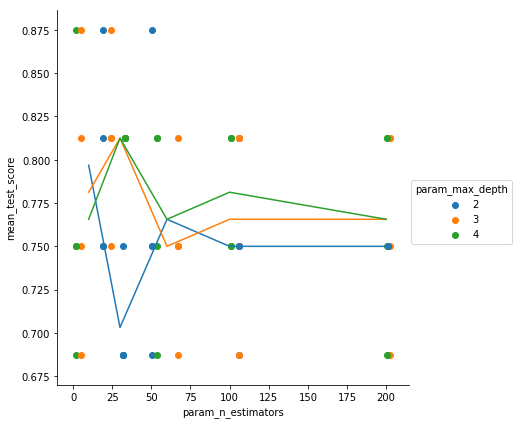

In [25]:
import seaborn as sns
g = sns.FacetGrid(cv_results, hue = 'param_max_depth', size = 6)
# xlim = (cv_results['param_n_estimators'].min(), cv_results['param_n_estimators'].max())
cv_results['param_n_estimators_jitter'] = cv_results['param_n_estimators'] + np.random.uniform(-10,10,size=len(cv_results))
for col in cv_results.columns:
    if re.search('split[0-9]_test_score', col):
        
        g.map(plt.scatter, 'param_n_estimators_jitter', col)
g.map(plt.plot, 'param_n_estimators', 'mean_test_score')
g.add_legend()
plt.show()


## Find top 30

In [26]:
X_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), features]
name_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), 'name']

In [27]:
best_clf = clf_gs.best_estimator_
y_other = best_clf.predict_proba(X_other)[:,1]

In [28]:
results = pd.DataFrame({'name':name_other, 'score':y_other})

In [29]:
results.sort_values('score', ascending=False)['name'].head(30)

651     Lily-Rose
713        Léonie
384        Giulia
649         Lilou
277        Eloïse
703          Lucy
702         Lucie
537        Juliet
799           Mia
34         Alizée
539        Juline
644          Lila
191         Cilou
272         Ellie
496        Jeanne
905        Renske
671        Liyana
281      Eléonore
808         Miley
620         Lente
13        Alessia
386        Gloria
618         Lenke
879           Ona
1082       Yinthe
449         Inara
53         Amélia
1083        Ylana
684        Lorena
707          Lune
Name: name, dtype: object

## Estimate model performance

In [30]:
cv_score = cross_val_predict(best_clf,X,y, cv=4,n_jobs=-1, method='predict_proba')[:,1]

In [31]:
model_df['cv_score'] = cv_score

In [32]:
%time best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
%time clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

CPU times: user 4.6 ms, sys: 2.76 ms, total: 7.36 ms
Wall time: 6.25 ms
CPU times: user 4.21 ms, sys: 1.06 ms, total: 5.28 ms
Wall time: 7.11 ms


In [33]:
questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
questions

,best_score,clicked
question_id,,
LxAwNQ8H587d0RLnnXnd_1,Niene,Marie-Lou
LxAwNQ8H587d0RLnnXnd_11,Lou,Lou
LxAwNQ8H587d0RLnnXnd_12,Norah,Esmee
LxAwNQ8H587d0RLnnXnd_13,Lilly,Lilly
LxAwNQ8H587d0RLnnXnd_14,Zita,Leonie
LxAwNQ8H587d0RLnnXnd_16,Elodie,Maud
LxAwNQ8H587d0RLnnXnd_17,Elle,Elle
LxAwNQ8H587d0RLnnXnd_18,Rosie,Rosie
LxAwNQ8H587d0RLnnXnd_19,Juna,Juna


In [34]:
(questions['clicked'] == questions['best_score']).mean()

0.5625

## Estimate performance on many users

In [35]:
correctness = {}
for model_id in df['model_id'].drop_duplicates().sample(50):
    model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name', how='inner')
    X = model_df[features]
    y = model_df['target']
    #clf_gs.fit(X,y)
    cv_score = cross_val_predict(best_clf,X,y, cv=3, method='predict_proba', n_jobs=-1)[:,1]
    model_df['cv_score'] = cv_score
    best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
    clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()
    questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
    correctness[model_id] = (questions['clicked'] == questions['best_score']).mean()
correctness = pd.Series(correctness)

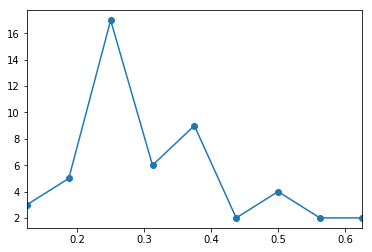

In [36]:
pd.Series(correctness).value_counts().sort_index().plot(marker='o')

In [37]:
correctness.mean()

0.32124999999999998

# Collaborative filtering

In [38]:
ratings = df.pivot(index = 'user_id', columns='name', values='feedback').fillna(0)
ratings.head()

name,Ada,Aisha,Alessia,Alexandra,Alexia,Alexis,Alice,Alicia,Alina,Aline,...,Yasmine,Yentl,Yoni,Yousra,Yuna,Zara,Zeynep,Zita,Zoé,Zoë
user_id,,,,,,,,,,,,,,,,,,,,,
00WQgk7c0TRsdwk606uw,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
01MkGWJ49xqLWclsY2h8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
01ndQFWoCqJe4XYI9wjs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02A9VJQzht3DfX6GXdp6,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
02Fs8PQ5u7hqJNMc47vE,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
similarity = cosine_similarity(ratings)
names = ratings.index
similarity = pd.DataFrame(similarity, index = names, columns = names)
similarity.head()

user_id,00WQgk7c0TRsdwk606uw,01MkGWJ49xqLWclsY2h8,01ndQFWoCqJe4XYI9wjs,02A9VJQzht3DfX6GXdp6,02Fs8PQ5u7hqJNMc47vE,02G5M6MPXneOGy78AEWq,02gRpaiYi7BniGfLq3Ot,02mqek6W3wNj1WLcmPcy,03vnXJfPuXT658YV5kFs,03yNaSkzrAvhI6m4JCDL,...,zsHFOTpE9mgzWYaTjfcs,zsJTzSvSttfoLcV9c8SB,zsbZ9roL7ip7heQCsAEG,zskqCXdos5iKIXkEqgGD,ztXduR9eLsWywohJ83pR,zvKCa6E9WjqrpUaHwTIZ,zxlKHhDg8vJ3g3WnI0DC,zyP49qpWksQlcghVfZDz,zyhPWKsqh2JTaH3HdSwM,zzL26RnRcrqFrSjzzjcv
user_id,,,,,,,,,,,,,,,,,,,,,
00WQgk7c0TRsdwk606uw,1.000000,0.151042,0.031250,0.088542,0.036458,0.010417,0.010417,0.166667,0.583333,0.015625,...,0.072917,0.151042,-0.057292,0.010417,0.026042,0.067708,0.088542,0.041667,0.031250,0.062500
01MkGWJ49xqLWclsY2h8,0.151042,1.000000,-0.026042,-0.015625,0.114583,-0.088542,-0.015625,-0.020833,0.088542,-0.098958,...,0.244792,0.036458,-0.062500,-0.005208,0.098958,0.140625,0.250000,0.072917,-0.010417,-0.114583
01ndQFWoCqJe4XYI9wjs,0.031250,-0.026042,1.000000,-0.031250,-0.072917,-0.010417,0.026042,0.026042,0.052083,0.104167,...,-0.010417,0.000000,0.104167,-0.010417,-0.005208,-0.052083,0.057292,0.005208,-0.015625,0.088542
02A9VJQzht3DfX6GXdp6,0.088542,-0.015625,-0.031250,1.000000,0.015625,0.156250,-0.031250,0.140625,-0.015625,0.005208,...,0.052083,0.052083,-0.026042,0.135417,0.083333,-0.046875,0.026042,-0.104167,0.083333,-0.020833
02Fs8PQ5u7hqJNMc47vE,0.036458,0.114583,-0.072917,0.015625,1.000000,-0.062500,-0.072917,0.010417,0.036458,-0.020833,...,-0.041667,0.057292,-0.041667,-0.020833,-0.046875,0.005208,0.093750,-0.010417,-0.026042,-0.052083


In [40]:
# Set self-similarity to 0 in order to avoid that a user uses his own feedback for recommendations
for name in names:
    similarity.loc[name, name] = 0
similarity.head()

user_id,00WQgk7c0TRsdwk606uw,01MkGWJ49xqLWclsY2h8,01ndQFWoCqJe4XYI9wjs,02A9VJQzht3DfX6GXdp6,02Fs8PQ5u7hqJNMc47vE,02G5M6MPXneOGy78AEWq,02gRpaiYi7BniGfLq3Ot,02mqek6W3wNj1WLcmPcy,03vnXJfPuXT658YV5kFs,03yNaSkzrAvhI6m4JCDL,...,zsHFOTpE9mgzWYaTjfcs,zsJTzSvSttfoLcV9c8SB,zsbZ9roL7ip7heQCsAEG,zskqCXdos5iKIXkEqgGD,ztXduR9eLsWywohJ83pR,zvKCa6E9WjqrpUaHwTIZ,zxlKHhDg8vJ3g3WnI0DC,zyP49qpWksQlcghVfZDz,zyhPWKsqh2JTaH3HdSwM,zzL26RnRcrqFrSjzzjcv
user_id,,,,,,,,,,,,,,,,,,,,,
00WQgk7c0TRsdwk606uw,0.000000,0.151042,0.031250,0.088542,0.036458,0.010417,0.010417,0.166667,0.583333,0.015625,...,0.072917,0.151042,-0.057292,0.010417,0.026042,0.067708,0.088542,0.041667,0.031250,0.062500
01MkGWJ49xqLWclsY2h8,0.151042,0.000000,-0.026042,-0.015625,0.114583,-0.088542,-0.015625,-0.020833,0.088542,-0.098958,...,0.244792,0.036458,-0.062500,-0.005208,0.098958,0.140625,0.250000,0.072917,-0.010417,-0.114583
01ndQFWoCqJe4XYI9wjs,0.031250,-0.026042,0.000000,-0.031250,-0.072917,-0.010417,0.026042,0.026042,0.052083,0.104167,...,-0.010417,0.000000,0.104167,-0.010417,-0.005208,-0.052083,0.057292,0.005208,-0.015625,0.088542
02A9VJQzht3DfX6GXdp6,0.088542,-0.015625,-0.031250,0.000000,0.015625,0.156250,-0.031250,0.140625,-0.015625,0.005208,...,0.052083,0.052083,-0.026042,0.135417,0.083333,-0.046875,0.026042,-0.104167,0.083333,-0.020833
02Fs8PQ5u7hqJNMc47vE,0.036458,0.114583,-0.072917,0.015625,0.000000,-0.062500,-0.072917,0.010417,0.036458,-0.020833,...,-0.041667,0.057292,-0.041667,-0.020833,-0.046875,0.005208,0.093750,-0.010417,-0.026042,-0.052083


In [41]:
# Choose a random user to provide recommendations to
random_user_id = ratings.sample().index[0]
random_user_id

'BJK7k3lV8UudOm4cN9RK'

In [42]:
# Find the 35 most similar users
similar_users = similarity[random_user_id].sort_values(ascending=False).head(35).index
similar_users

Index(['qWjgG3hC2WTdqim39FcJ', 'PshzfzK2rnFMVWa3VGxL', 'DsOPe7EKIZpKIrpuaBrg',
       'wuBgrasNZfaaMexo9yxF', 'mkBukV8cSp6ByyjIdvpB', 'mj26yW5SOYOC7uQ6GJHb',
       'eDhfzZr4ZyzJEfSo1NTm', 'wn51mcn2xyvLAw5oI2mC', 'mAnqPuJF8IlT42lomObb',
       '5hZBV4EPIuLo2CqFQlvt', 'UOv0zjQI5MNjqTUl1a5J', 'E5l0XSc2GA5ohzurmBSZ',
       'vA8xvBZ9WqaukQSHQdKm', 'dDjFhBXCSNXe8adHupes', '0OwYHeFcEla07qJjoTzl',
       'GVt2Lsy1XYQBfpnKX13X', '8u4fuGqmM8VjGcBpOi1o', '3tnFN7TlakCda9kIQP3h',
       '2glWKeYVZehLDMMSiV2r', '0KIHx5P3zpKSbZOJJELv', 'UZ9C5K40m8oyCJvQvvR5',
       'prGEnx4UlbBOnieOxFeH', 'AX2djld2J0Lz4wx2WGZv', 'qiyVokrGPJzFmJcCfd7V',
       'K6J0nS9AtLZ7DdTISlRm', 'LbhEEN1c9DKC08Boane5', 'G01bvGhahsQoG8M9vcoB',
       '0rn4vAbHSsllvvoZ2SsI', 'rMGI4YHAfSqyNgd5qn8p', '6rOMV7E7qIvHYvRcEqiQ',
       'woaLyCbSwHpokk3SEeUd', 'zgdd6ecmVCj8ixCOdWhX', 'eN2BrGRFTUZLt4iI9yEC',
       'lrV5ps5VjvSSTSnb8BE0', 'K39ZGFNwY2AZMaUBdlQU'],
      dtype='object', name='user_id')

In [43]:
# Take the average rating of the similar users, only for names the random user has not rated, and take the top 30
user_ratings = ratings.loc[random_user_id]
ratings_from_similar_users = ratings.loc[similar_users, user_ratings==0].mean()
ratings_from_similar_users.sort_values(ascending=False).head(30)

name
Emma         1.142857
Lotte        1.057143
Noor         0.885714
Ella         0.857143
Marie        0.771429
Mila         0.628571
Niene        0.600000
Elise        0.571429
Amelie       0.542857
Louise       0.514286
Feline       0.514286
Fien         0.428571
Marthe       0.428571
Lore         0.400000
Liv          0.342857
Lauren       0.285714
Charlotte    0.285714
Noémie       0.285714
Lise         0.285714
Maxine       0.257143
Manon        0.257143
Lieze        0.257143
Elle         0.257143
Lola         0.257143
Lene         0.257143
Leonie       0.228571
Flore        0.200000
Anna         0.200000
Milla        0.200000
Nona         0.200000
dtype: float64